# HYBRID RECOMMENDATION SYSTEM USING BERT AND NEURAL NETWORKS FOR E-COMMERCE

In [ ]:
# Import python libraries
import os
import numpy as np
from numpy import *
import pandas as pd
import re
import datetime as dt
# Import Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Import scikit learn libraries
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
# Import Cosine and Adjusted Cosine similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
# Import pickle to save and load the model
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Data Sourcing

Load the data from the input file

In [ ]:
DATA_DIRECTORY = "/data-direcrtory-path/"
dataFileName = DATA_DIRECTORY + "Amazon_Fashion.jsonl"
df = pd.read_json(dataFileName, lines=True)

Print shape and first 5 rows

In [ ]:
print(df.shape)
df.head()

(2500939, 10)


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09 00:06:34.489,3,True
1,5,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20 01:04:06.701,0,True
2,2,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23 01:33:48.000,3,True
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31 20:57:27.095,2,True
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13 14:29:26.000,0,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500939 entries, 0 to 2500938
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int64         
 1   title              object        
 2   text               object        
 3   images             object        
 4   asin               object        
 5   parent_asin        object        
 6   user_id            object        
 7   timestamp          datetime64[ns]
 8   helpful_vote       int64         
 9   verified_purchase  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 174.1+ MB


### Exploratory Data Analysis

- Start with Handling Null values

In [ ]:
def MissingData(df):
    # summing up the missing values (column-wise) and displaying fraction of NaNs
    null_count = df[df.columns[df.isna().any()]].isna().sum().sort_values(ascending=False)
    null_percentage = (
        df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]
    ).sort_values(ascending=False)
    null_data = pd.concat([null_count, null_percentage], axis=1, keys=["Count", "Percentage"])
    return null_data

In [ ]:
MissingData(df)

,Count,Percentage


No Missing values

Check column images and drop as it will not be used for recommendation model building

In [ ]:
df.drop(columns=["images"], axis=1, inplace=True)

- Checking for duplicate rows

In [ ]:
# Checking for duplicate rows in the dataset
duplicate_count = df[df.duplicated() == True].shape[0]
print("Duplicate records count", duplicate_count)

Duplicate records count 25244


There are 25244 duplicate purchase data records, so these will be filtered as this will impact the further inference and model building

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
def print_user_items_count(data: pd.DataFrame):
    print("Dataset shape:", data.shape, "Users count:", data.user_id.nunique(), "Items count:", data.parent_asin.nunique())

print_user_items_count(df)

Dataset shape: (2475695, 9) Users count: 2035490 Items count: 825869


##### Analyze the verified purchase feature

In [ ]:
df.verified_purchase.value_counts(normalize=True)

,proportion
verified_purchase,
True,0.934717
False,0.065283


Approximately 93.5% users items interactions are verified purchase and some 6.5% users have unverified purchase

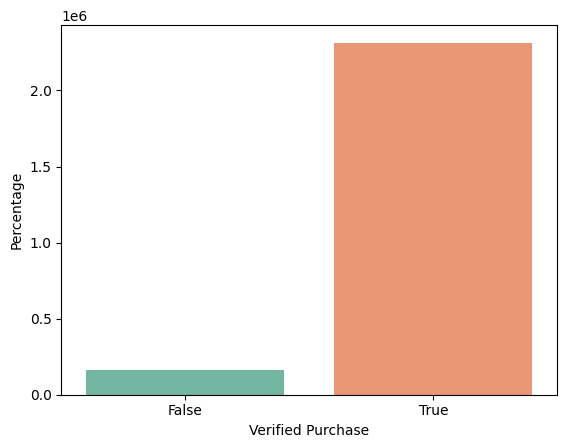

In [ ]:
# Visualize using count plot
sns.countplot(x="verified_purchase", data=df, palette="Set2")
plt.xlabel("Verified Purchase")
plt.ylabel("Percentage")
plt.show()

We can see user verified purchase are way higher than unverified purchase

In [ ]:
# Map the categorical verified_purchase to numerical 1 or 0 for Classification Model
df["verified_purchase"] = df["verified_purchase"].map({True: 1, False: 0})
# get the value count of verified_purchase column
df["verified_purchase"].value_counts(normalize=True)

,proportion
verified_purchase,
1,0.934717
0,0.065283


##### Analyze the Rating feature

In [ ]:
df["rating"].value_counts(normalize=True)

,proportion
rating,
5,0.570299
4,0.140945
1,0.121194
3,0.098215
2,0.069347


Approximately 81% of reviews have rating of 3 and above. 57% of the reviews have rating of 5. 14% have rating of 4 and 10% have rating of 3

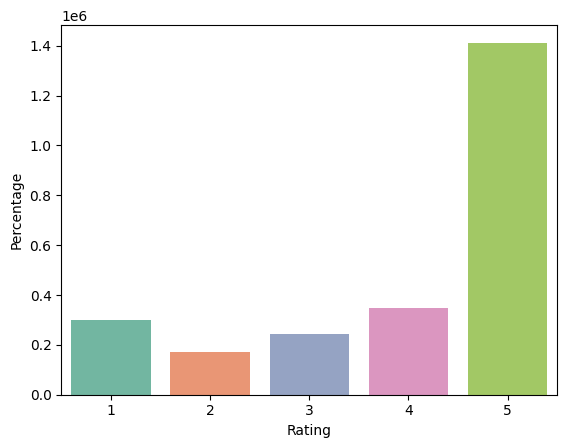

In [ ]:
# visualize the rating.
sns.countplot(x="rating", data=df, palette="Set2")
plt.xlabel("Rating")
plt.ylabel("Percentage")
plt.show()

<Axes: xlabel='rating'>

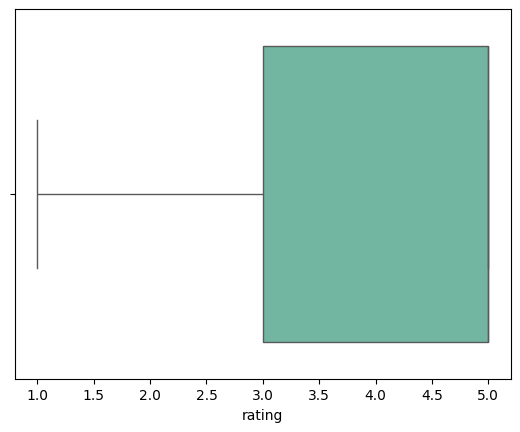

In [ ]:
plt.rcdefaults()
sns.boxplot(x="rating", data=df, palette="Set2")

Most of the rating ranges from 3 to 5. So this will be used for data filtraion with minimum rating of 3.

##### Analyze the Rating and verified purchase for correlation analysis

Check the ratings for positive sentiment records

In [ ]:
df[df["verified_purchase"] == 1]["rating"].value_counts(normalize=True)

,proportion
rating,
5,0.572208
4,0.138855
1,0.121539
3,0.097832
2,0.069566


Check the ratings and verified_purchase correlation

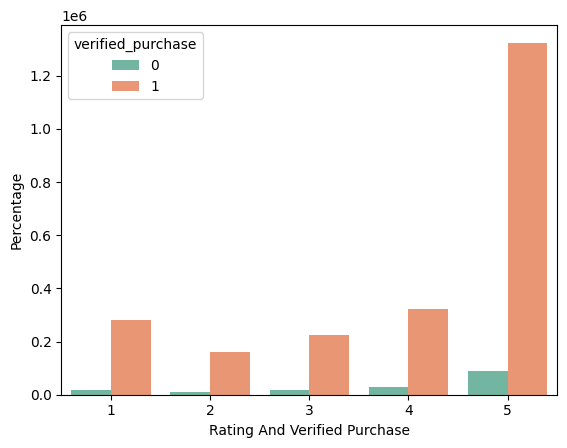

In [ ]:
plt.rcdefaults()
sns.countplot(x="rating", data=df, hue='verified_purchase', palette='Set2')
plt.xlabel("Rating And Verified Purchase")
plt.ylabel("Percentage")
plt.show()

##### Analyze Helpful Vote feature


In [ ]:
df.helpful_vote.describe()

,helpful_vote
count,2.475695e+06
mean,5.662022e-01
std,3.785516e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,9.540000e+02


In [ ]:
df.helpful_vote.value_counts(normalize=True)

,proportion
helpful_vote,
0,8.021129e-01
1,1.154940e-01
2,3.485203e-02
3,1.564571e-02
4,8.523667e-03
...,...
323,4.039270e-07
213,4.039270e-07
394,4.039270e-07


<Axes: xlabel='helpful_vote'>

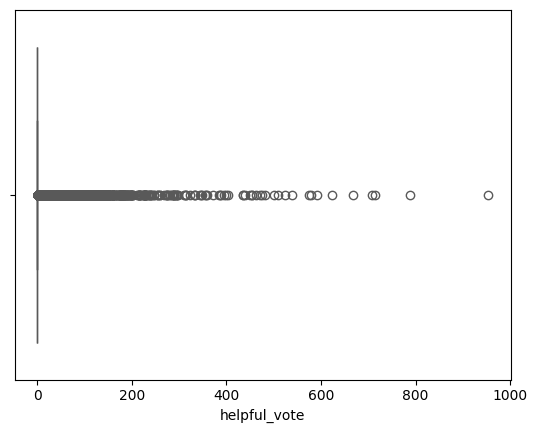

In [ ]:
sns.boxplot(x="helpful_vote", data=df, palette="Set2")

In [ ]:
#print the quantile (0.5, 0.7, 0.9, 0.95 and 0.99) of balance variable
df.helpful_vote.quantile([0.5,0.7, 0.9, 0.95, 0.99, 0.995, 0.9995])

,helpful_vote
0.5000,0.000
0.7000,0.000
0.9000,1.000
0.9500,2.000
0.9900,9.000
0.9950,14.000
0.9995,57.153


In [ ]:
df["helpful_vote_Rel"] = df.helpful_vote.apply(lambda x: 1 if x >= 1 else 0)
df.helpful_vote_Rel.value_counts(normalize=True)

,proportion
helpful_vote_Rel,
0,0.802113
1,0.197887


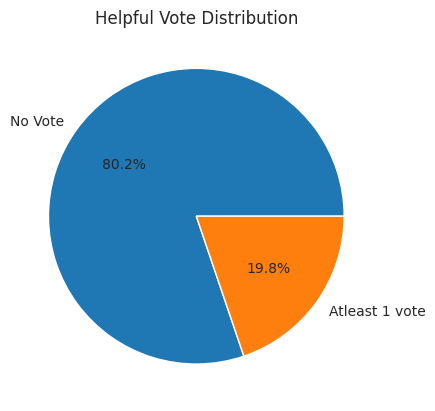

In [ ]:
sns.set_style("whitegrid")
plt.pie(df["helpful_vote_Rel"].value_counts(normalize=True), labels=['No Vote', 'Atleast 1 vote'], autopct="%1.1f%%")
plt.title("Helpful Vote Distribution")
plt.show()

As we see that almost 80% of the purchase data either doesn't have any helpful votes.

In [ ]:
#create the buckets of <5, 5-10, 10-20, 20-50, 50-100, 100-200, 200-500, 500+ column.
df['helpful_vote_range'] = pd.cut(df.helpful_vote, [0, 5, 10, 20, 50, 100, 200, 500, 9999],
            labels=["<5", "5-10", "10-20", "20-50", "50-100", "100-200", "200-500", "500+"])
df.helpful_vote_range.value_counts(normalize=True)

,proportion
helpful_vote_range,
<5,0.908744
5-10,0.052902
10-20,0.024470
20-50,0.010767
50-100,0.002225
100-200,0.000676
200-500,0.000190
500+,0.000027


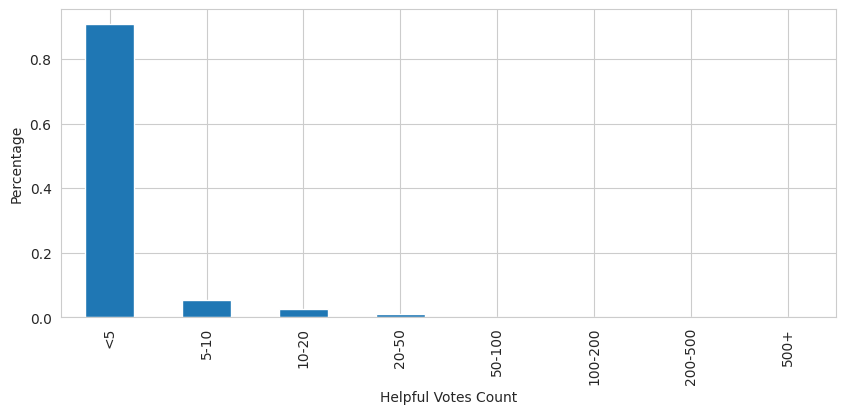

In [ ]:
plt.figure(figsize=[10, 4])
df.helpful_vote_range.value_counts(normalize=True).plot.bar()
plt.xlabel("Helpful Votes Count")
plt.ylabel("Percentage")
plt.show()

 Among the rest 20%, approximately 90% of then have less than or equal to 5 votes. Hence this feature doesn't hold any significance for building the recommendation model.

##### Analyze Timestamp feature

Convert the timestamp to days count from the last purchase date

In [ ]:
print("Most Frequent Purchase date -", df['timestamp'].max())
print("Most Historic Purchase date -", df['timestamp'].min())

Most Frequent Purchase date - 2023-09-11 03:24:38.515000
Most Historic Purchase date - 2002-05-07 01:51:28


In [ ]:
df['time_seconds'] = df.timestamp.apply(lambda x: int(x.timestamp()))

In [ ]:
#Calculate the past no of days from the current date to determine the purchase frequencey in days
# User's last purchase
df['timestamp_freqLast'] = (df['timestamp'].max() - df['timestamp']).dt.total_seconds()

In [ ]:
df['timestamp_freqDays'] = np.ceil(df['timestamp_freqLast']/(60*60*24))
df['timestamp_freqDays'] = df['timestamp_freqDays'].apply(lambda x : 1 if x == 0.0 else x)
df['timestamp_freqDays'] = np.round(df['timestamp_freqDays'])

Users purchasing count in weeks/months interval. 1 month, 2-3 months, 3-6 months, 6-9 months, 6-12 months, 12-15 months, 15-18 months, 18-21 months, 21-24 months, 2-2.5years, more than 2.5 years with an interval of 6 months

In [ ]:
#create the buckets of <1 month, 1-3 months, 3-6 months, 6-9 months, 9-12 months, 12-15 months,
# 15-18 months, 18-21 months, 21-24 months, 2-2.5years, more than 2.5 years with an interval of 6 months
# from timestamp column.
df['purchase_freq'] = pd.cut(df.timestamp_freqDays, [0, 30, 90, 180, 272, 365, 450, 540, 630, 720,
                                    900, 1080, 1260, 1440, 1620, 1800, 1980, 2160, 3340, 3520, 3700,
                                    3880, 4060, 4240, 4420, 4600, 4780, 4960, 9999],
        labels=["<1 month", "1-3 months", "3-6 months", "6-9 months", "6-12 months",
            "12-15 months", "15-18 months", "18-21 months", "21-24 months", "2-2.5 years", "2.5-3 years",
            "3-3.5 years", "3.5-4 years", "4-4.5 years", "5-5.5 years", "5.5-6 years", "6-6.5 years",
            "6.5-7 years", "7-7.5 years", "7.5-8 years", "8-8.5 years", "8.5-9 years", "9-9.5 years",
            "9.5-10 years", "10-10.5 years", "10.5-11 years", "11-11.5 years", "11.5+ years"])
df.purchase_freq.value_counts()

,count
purchase_freq,
6.5-7 years,744797
3.5-4 years,207661
4-4.5 years,200466
5-5.5 years,185679
5.5-6 years,177466
6-6.5 years,173054
2.5-3 years,169350
2-2.5 years,157470
3-3.5 years,124851


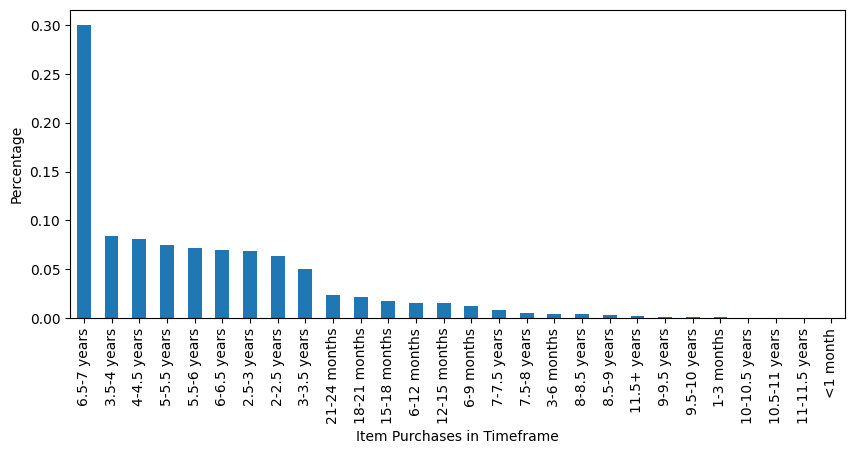

In [ ]:
plt.rcdefaults()
plt.figure(figsize=[10, 4])
df.purchase_freq.value_counts(normalize=True).plot.bar()
plt.xlabel("Item Purchases in Timeframe")
plt.ylabel("Percentage")
plt.show()

User Item purchase distribution across month

In [ ]:
df['purchase_month'] = df.timestamp.apply(lambda x : x.month)

In [ ]:
months_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
              7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

In [ ]:
df.purchase_month = df.purchase_month.map(months_map)

In [ ]:
df.purchase_month.value_counts(normalize=True)

,proportion
purchase_month,
Jan,0.102408
Dec,0.098877
Jul,0.088751
Aug,0.086529
Mar,0.083500
Jun,0.080892
Oct,0.080295
Feb,0.079400
May,0.077035


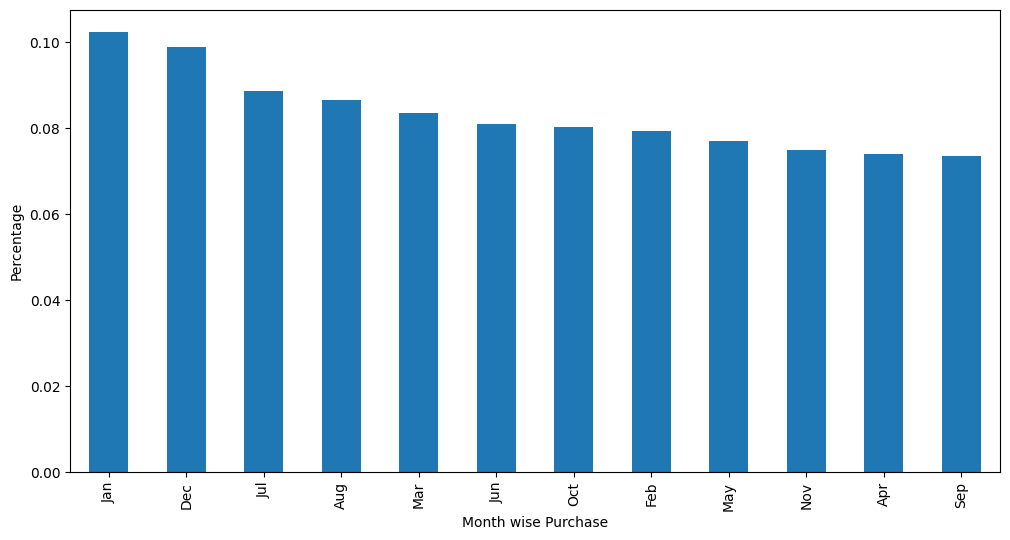

In [ ]:
plt.figure(figsize=[12, 6])
df.purchase_month.value_counts(normalize=True).plot.bar()
plt.xlabel("Month wise Purchase")
plt.ylabel("Percentage")
plt.show()

The purchases across the months have been consistent with an average weightage, 7.5% of total purchasings in every month. This is almost equally distributed. Among these, January, December and July are being the top 3 months with maximum purchasings and this shows some seasonality, considering winter and summer peak months.

In [ ]:
df['purchase_year'] = df.timestamp.apply(lambda x : x.year)

In [ ]:
df.purchase_year.value_counts(normalize=True)

,proportion
purchase_year,
2019,0.164820
2017,0.148668
2018,0.147839
2020,0.124891
2021,0.123844
2016,0.115389
2022,0.069596
2015,0.051195
2014,0.023832


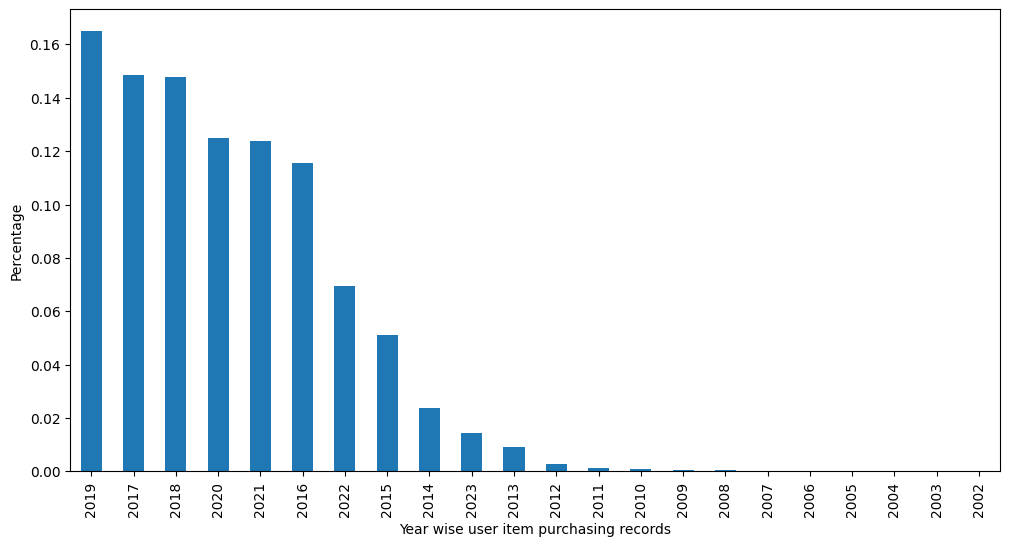

In [ ]:
plt.figure(figsize=[12, 6])
df.purchase_year.value_counts(normalize=True).plot.bar()
plt.xlabel("Year wise user item purchasing records")
plt.ylabel("Percentage")
plt.show()

In [ ]:
df.groupby(by="purchase_year")['user_id'].count()

,user_id
purchase_year,
2002,6
2003,10
2004,34
2005,69
2006,152
2007,855
2008,1162
2009,1400
2010,1852


In [ ]:
df.groupby(by="purchase_year")['user_id'].nunique()

,user_id
purchase_year,
2002,6
2003,10
2004,34
2005,67
2006,149
2007,829
2008,1122
2009,1348
2010,1810


In [ ]:
df.groupby(by="purchase_year")['parent_asin'].count()

,parent_asin
purchase_year,
2002,6
2003,10
2004,34
2005,69
2006,152
2007,855
2008,1162
2009,1400
2010,1852


In [ ]:
df.groupby(by="purchase_year")['parent_asin'].nunique()

,parent_asin
purchase_year,
2002,5
2003,10
2004,26
2005,60
2006,119
2007,668
2008,807
2009,1039
2010,1406


We see that both users and items, earlier than past 10 years (2013) are less and both have grown with almost same rate which clearly indicates the high sparisty in data.

### Data Preparation

In [ ]:
print("Start Data Filtration")
print_user_items_count(df)

Start Data Filtration
Dataset shape: (2475695, 17) Users count: 2035490 Items count: 825869


Filter the data with verified purchase as False

In [ ]:
df[df.verified_purchase == False].shape

(161622, 17)

In [ ]:
df = df[~(df.verified_purchase == False)]

In [ ]:
print("After filtering with verified_purchase = True")
print_user_items_count(df)

After filtering with verified_purchase = True
Dataset shape: (2314073, 17) Users count: 1937340 Items count: 776976


Filter the data with rating less than 3 as these will not be potential items for next purchasings

In [ ]:
MIN_RATING = 3
df = df[~(df.rating < MIN_RATING)]

In [ ]:
print("After filtering with min rating of 3")
print_user_items_count(df)

After filtering with min rating of 3
Dataset shape: (1871843, 17) Users count: 1590637 Items count: 660679


Drop extra columns

In [ ]:
df.drop(columns=['timestamp', 'timestamp_freqLast', 'timestamp_freqDays', 'asin', 'purchase_month',
                 'purchase_freq', 'purchase_year', 'helpful_vote_range', 'helpful_vote_Rel'], axis=1, inplace=True)

#### Data Transformation

In [ ]:
print("Filtered Users and Items for the Sentiment task model")
print_user_items_count(df)

Filtered Users and Items for the Sentiment task model
Dataset shape: (1871843, 8) Users count: 1590637 Items count: 660679


##### Define sentiment label column
This will be used to capture user sentiment. 1=Positive, 0=Negative

In [ ]:
df.text[:5]

,text
0,I think this locket is really pretty. The insi...
1,Great
4,I LOVE these glasses! They fit perfectly over...
5,Works OK for adults and is not at all kid frie...
6,Great fit


Standardise the text for processing

In [ ]:
def text_standardization(input):
    punctuations = r"""!"#$%&'()*+,-/:;<=>?@[\]^_`{|}~"""
    lowercase = tf.strings.lower(input)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    text = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(punctuations), '')
    text = str(text)[12:-26][:500] # consider text max 500 words
    return text.strip()

In [ ]:
df['text'] = df.text.apply(lambda x : text_standardization(x))

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

##### Sentiment Labeling based on review text

In [ ]:
print("Sentiment Label task modeling", len(list(df['text'][:5])), "\n", df['text'][:5])

In [ ]:
from sentiment_classification import SentimentClassification
#import SentimentClassification

In [ ]:
sentimentClassifier = SentimentClassification()

In [ ]:
BATCH_SIZE = 8
sentiment_labels = sentimentClassifier.get_sentiment_labels(df, "text", BATCH_SIZE)

In [ ]:
sentiment_labels[:10]

In [ ]:
sentiment_labels = pd.DataFrame(sentiment_labels)
sentiment_labels.columns = ["sentiment_label"]
sentiment_labels.head()

In [ ]:
df = pd.concat([df, sentiment_labels], axis = 1)
df.head()

In [ ]:
df.sentiment_label.value_counts(normalize=True)

Filter the records with negative sentiments, i.e sentiment_label as 0

In [ ]:
df = df[~(df.sentiment_label == 0)]
df.reset_index(drop=True, inplace=True)

In [ ]:
print("Filtering with positive sentiment labelled data")
print_user_items_count(df)

Arrange the user items data in a sequential manner based on timestamp in chronological order of purchase. For a user the recent item purchase will be in the last of the item sequence.

In [ ]:
print("Start Data transformation for Recommendation Model")
df = df.sort_values('time_seconds')
df.head()

##### Filter the users which have atleast 5 historical items data

In [ ]:
# Grouping the data by users to create item sequences for CBF model
df_user_items_count = pd.DataFrame(df.groupby("user_id")["parent_asin"].count())
df_user_items_count.columns = ["items_count"]
print("Max Items rated by an user", df_user_items_count.items_count.max())
print("Min Items rated by an user", df_user_items_count.items_count.min())
df_user_items_count[df_user_items_count.items_count == df_user_items_count.items_count.max()]

In [ ]:
df_user_items_count.items_count.describe()

In [ ]:
MIN_NO_OF_ITEMS = 3
user_items_count = df_user_items_count[df_user_items_count.items_count >= MIN_NO_OF_ITEMS]
user_items_count = user_items_count.reset_index()
user_items_count

In [ ]:
user_items_count.items_count.sum()

In [ ]:
users = np.array(user_items_count.user_id)
user_items_count = None
df_user_items = df[df.user_id.isin(users)].sort_values(["user_id", "time_seconds"], ascending=[True, False])[["user_id", "rating", "parent_asin", "time_seconds"]]
df_user_items.head()

In [ ]:
print("Filtering the users which have atleast 5 historical items data")
print_user_items_count(df_user_items)

In [ ]:
# Importing application modules
from tokenization.simple_tokenizer import *

In [ ]:
MODE_USER_ITEM='user_item'
MODE_ITEM_USER='item_user'

In [ ]:
def createTokenizedFile(data, filename, mode, ncf=False):
    print("Creating tokeinzed file for mode:", mode, "Filename:", filename)
    user_tokenizer = SimpleTokenizer()
    item_tokenizer = SimpleTokenizer()
    with open(filename, "wb") as file:
        if mode == MODE_USER_ITEM:
            for rec in data.itertuples():
                user_token = user_tokenizer.tokenize(rec.user_id)
                item_token = item_tokenizer.tokenize(rec.parent_asin)
                if ncf:
                    user_item_token = str(user_token) + "::" + str(item_token) + "::" + str(rec.rating) + "::" + str(rec.time_seconds)
                else:
                    user_item_token = str(user_token) + " " + str(item_token)
                #if (user_token < 5):
                    #print(user_item_token)
                line = user_item_token + os.linesep
                line = bytes(line, "utf-8")
                file.write(line)
        elif mode == MODE_ITEM_USER:
            for rec in data.itertuples():
                item_token = item_tokenizer.tokenize(rec.parent_asin)
                user_token = user_tokenizer.tokenize(rec.user_id)
                if ncf:
                    item_user_token = str(item_token) + "::" + str(user_token) + "::" + str(rec.rating) + "::" + str(rec.time_seconds)
                else:
                    item_user_token = str(item_token) + " " + str(user_token)
                #if (item_token < 5):
                    #print(item_user_token)
                line = item_user_token + os.linesep
                line = bytes(line, "utf-8")
                file.write(line)
        else:
            print("Invalid mode, it should be either 'user_item' or 'item_user'")
        file.close()

In [ ]:
createTokenizedFile(data=df_user_items, filename='user_item.txt', mode=MODE_USER_ITEM)

##### Filter Items which have been rated by atleast 20 users

In [ ]:
df_items_user_count = pd.DataFrame(df.groupby("parent_asin")["user_id"].count())
df_items_user_count.columns = ["user_count"]
print("Item rated by Max Users", df_items_user_count.user_count.max())
print("Item rated by Min Users", df_items_user_count.user_count.min())
df_items_user_count[df_items_user_count.user_count == df_items_user_count.user_count.max()]

In [ ]:
df_items_user_count.user_count.describe()

In [ ]:
df_items_user_count.user_count.quantile([0.5,0.7, 0.9, 0.95, 0.99, 0.995, 0.9995, 0.9999, 1])

In [ ]:
df_items_user_count[df_items_user_count.user_count >= 100].count()

Grouping the data by items to create user sequences for CF model

In [ ]:
df_item_rank = pd.DataFrame(df.groupby('parent_asin')['time_seconds'].rank(method='first', ascending=False))
# Creating the rank column for taking N recent sequence
df_item_rank.columns = ['rank']
df_item_rank.shape

In [ ]:
df_item_users = pd.merge(df, df_item_rank, left_index=True, right_index=True)
df_item_users.head()

To make the model not overfit with large user sequence we take recent user sequence of 100

In [ ]:
MIN_NO_OF_USERS = 20
MAX_NO_OF_USERS = 100
items_user_count = df_items_user_count[(df_items_user_count.user_count >= MIN_NO_OF_USERS)]
items_user_count = items_user_count.reset_index()
items_user_count

In [ ]:
items_user_count.user_count.sum()

In [ ]:
items = np.array(items_user_count.parent_asin)
df_item_users = df_item_users[df_item_users.parent_asin.isin(items) & (df_item_users['rank'] <= MAX_NO_OF_USERS)].sort_values(["parent_asin", "time_seconds"])[["user_id", "rating", "parent_asin", "time_seconds", "rank"]]
df_item_users.head()

In [ ]:
print("Filtering Items which have been rated by atleast", MIN_NO_OF_USERS, "users")
print_user_items_count(df_item_users)

In [ ]:
createTokenizedFile(data=df_item_users, filename='item_user.txt', mode=MODE_ITEM_USER)

In [ ]:
final_user_items = pd.concat([df_user_items, df_item_users], axis=0)

In [ ]:
print("After combining item-based and user-based data")
print_user_items_count(final_user_items)

In [ ]:
# Removing duplicate rows if present in the dataset
duplicate_count = final_user_items[final_user_items.duplicated() == True].shape[0]
if duplicate_count > 0:
    print("Duplicate records count", duplicate_count)
    final_user_items.drop_duplicates(inplace=True)
    print("After dropping duplicate data")
    print_user_items_count(final_user_items)

### Model Building: Recommendation Model

We will build User-Item and Item-Item collaborative filtering recommendation system and compare their results<br>

- User-Item: Find similar users first and then recommend products to users which would have been rated high by the similar group of users<br>
- Item-Item: Find similar items based on ratings and use that to recommend the top rated products to users

Build the dataset needed for Recommendation Engine<br>
Earlier we had kept the dataset df intact for classification and recommendation

In [ ]:
# Verify df has no missing data
print("Start Model Building")

df = final_user_items.copy()
df.reset_index(drop=True, inplace=True)

MissingData(df)

df_recommendation = df[["user_id", "rating", "parent_asin"]]
print(df_recommendation.shape)

df_recommendation.head(5)

Split the recommendation dataset into train and test

In [ ]:
print("Train test data split ratio 80:20")

In [ ]:
train, test = train_test_split(df_recommendation, test_size=0.20, random_state=42)

In [ ]:
df_recommendation

Name columns for the recommendation dataset

In [ ]:
product_column = "parent_asin"
user_column = "user_id"
value_column = "rating"

Create pivot dataset in matrix format with columns as product IDs and rows as user names so we get a view of whch user has rated which product and what value

In [ ]:
df_user_recommendation_pivot = pd.pivot_table(
    train, index=user_column, columns=product_column, values=value_column
).fillna(0)
df_user_recommendation_pivot.head(10)

In [ ]:
df_user_recommendation_pivot.shape

##### Dummy train dataset

We will create dummy train and dummy test dataset to mark the products already rated by the user so that they dont come up during prediction or evaluation


In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()
# The products not rated by a user is marked as 1 for prediction. this matrix form now has 1 and 0 with 1 as products not rated by the user
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x >= 1 else 1)
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(
    dummy_train, index=user_column, columns=product_column, values=value_column
).fillna(1)
dummy_train.head(10)

Adjusted cosine similarity measure will be used now to capture similarities between different users.

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user, we subtract average ratings for each user from each user's rating for different products.

In [ ]:
df_user_recommendation_pivot.index.nunique()
# using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_user_recommendation_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

##### User-Based Recommendation Model

User - User similarity predicition with the use of above correlation matrix. no correlation value of 0<br>
Making negative correlations to 0

In [ ]:
user_correlation[user_correlation < 0] = 0

In [ ]:
# taking a dot product of User correlation matrix and the pivot matrix
user_predicted_ratings = np.dot(user_correlation, df_user_recommendation_pivot.fillna(0))
user_predicted_ratings

Multiply the predicted ratings with dummy matrix as we dont want the products which are already rated

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

Top 20 recommendations for a sample user

In [ ]:
user_input = df_recommendation["user_id"][5]
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]

Show the top 20 recommended products - product id, name and similarity_score

In [ ]:
final_recommendations = pd.DataFrame(
    {"product_id": recommendations.index, "similarity_score": recommendations}
)
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="parent_asin")[
    ["parent_asin", "similarity_score"]
].drop_duplicates()

Since prediction is now done, we will move to evaluation for User-User Collborative<br>
Find out the common users of test and train dataset.

In [ ]:
common = test[test.user_id.isin(train.user_id)]
common.shape
# Convert into the user-product matrix.
common_user_based_matrix = pd.pivot_table(
    common, index=user_column, columns=product_column, values=value_column
)
common_user_based_matrix.head()
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()
user_correlation_df[user_column] = df_user_recommendation_pivot.index
user_correlation_df.set_index(user_column, inplace=True)
user_correlation_df.head()

Get the list of users from the common dataset from train and test

In [ ]:
list_name = common.user_id.tolist()

Create a user correlation matrix with the list of common users in train and test by aligning the pivot matrix index

In [ ]:
user_correlation_df.columns = df_user_recommendation_pivot.index.tolist()
user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape
# create user correlation matrix 2 with a transpose of matrix 1 with the list of common users
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
# create user correlation matrix 2 with a transpose of matrix 2
user_correlation_df_3 = user_correlation_df_2.T
# Mark the correlattion value with 0 for the negative correlations
user_correlation_df_3[user_correlation_df_3 < 0] = 0
# get the recommendations by doing a dot product of correlations and ratings
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

Create a dummy test dataset with the common users and create a pivot matrix of the same

In [ ]:
dummy_recommendation_test = common.copy()
dummy_recommendation_test[value_column] = dummy_recommendation_test[value_column].apply(
    lambda x: 1 if x >= 1 else 0
)
dummy_recommendation_test = pd.pivot_table(
    dummy_recommendation_test, index=user_column, columns=product_column, values=value_column
).fillna(0)
dummy_recommendation_test.shape
# print both the matrix which has users and the evaluation test recommendations
common_user_based_matrix.head()
dummy_recommendation_test.head()
# get the final evaluation for the products not rated by the users in the test set
common_user_predicted_ratings = np.multiply(
    common_user_predicted_ratings, dummy_recommendation_test
)
print(common_user_predicted_ratings.head())

Calculate RMSE from the user-user evaluation

In [ ]:
X = common_user_predicted_ratings.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))
common_ = pd.pivot_table(common, index=user_column, columns=product_column, values=value_column)
#Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
user_rmse = (sum(sum((common_ - y) ** 2)) / total_non_nan) ** 0.5
# print the final RMSE
print("User-based RMSE", user_rmse)

##### Item-Based Recommendation Model

In [ ]:
# Item-Item Based Recommendation
df_item_recommendation_pivot = pd.pivot_table(
    train, index=product_column, columns=user_column, values=value_column
)
df_item_recommendation_pivot.head()

In [ ]:
mean = np.nanmean(df_item_recommendation_pivot, axis=1)
df_subtracted = (df_item_recommendation_pivot.T - mean).T
df_subtracted.head()

Create Item similarity matrix using cosine similarity

In [ ]:
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric="cosine")
item_correlation[np.isnan(item_correlation)] = 0

In [ ]:
item_correlation[item_correlation < 0] = 0
item_correlation

Prediction Item-Item recommendation

In [ ]:
item_predicted_ratings = np.dot((df_item_recommendation_pivot.fillna(0).T), item_correlation)
item_predicted_ratings
# filtering for the products not rated by the users
item_final_rating = np.multiply(item_predicted_ratings, dummy_train)
item_final_rating.head()

Top 20 recommendations for a sample user

In [ ]:
user_input = df_recommendation["user_id"][5]
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]

In [ ]:
# Show the top 20 recommended products - product id, name and similarity_score
item_final_recommendations = pd.DataFrame(
    {"product_id": item_recommendations.index, "similarity_score": item_recommendations}
)
item_final_recommendations.reset_index(drop=True)
pd.merge(item_final_recommendations, train, on="parent_asin")[
    ["parent_asin", "similarity_score"]
].drop_duplicates()

Now the prediction is done, let's do the evaluation for item - item recommendation

In [ ]:
common = test[test.parent_asin.isin(train.parent_asin)]
print(common.shape)
common.head(5)

In [ ]:
common_item_based_matrix = common.pivot_table(
    index=product_column, columns=user_column, values=value_column
)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

In [ ]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column, inplace=True)
item_correlation_df.head()

In [ ]:
list_name = common.parent_asin.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
# create a user correlation matrix with the list of common users in train and test by aligning the pivot matrix index
item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
# create correlations 3 with transpose of 2
item_correlation_df_3 = item_correlation_df_2.T
df_subtracted

Mark the correlation value with 0 for the negative correlations

In [ ]:
item_correlation_df_3[item_correlation_df_3 < 0] = 0
# get the recommendations by doing a dot product of correlations and ratings
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
print(common_item_predicted_ratings)

Create a dummy test dataset with the common users and create a pivot matrix of the same

In [ ]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x >= 1 else 0)
dummy_test = pd.pivot_table(
    dummy_test, index=product_column, columns=user_column, values=value_column
).fillna(0)
# get the final evaluation for the products not rated by the users in the test set
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)
common_ = pd.pivot_table(common, index=product_column, columns=user_column, values=value_column)

Calculate RMSE from the item-item evaluation

In [ ]:
X = common_item_predicted_ratings.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
item_rmse = (sum(sum((common_ - y) ** 2)) / total_non_nan) ** 0.5
# print the final rmse value
print("Item-based RMSE", item_rmse)

##### Recommendation Model selection

In [ ]:
recommendation_results = pd.DataFrame({"Recommendation Method": ['User-Based', 'Item-Based'],
              "Evaluation Metric(RMSE)" : [user_rmse, item_rmse]})
print(recommendation_results)

RMSE for User-User based recommendation method is almost equal to Item-Item, hence we will use both the User based and Item based collaborative filtering for building the Hybrid Recommendation model.

Saving the model

In [ ]:
# Pickle saved files directory
ML_MODELS_DIRECTORY = "model_files/"

In [ ]:
def save_model(model, filename):
    file_path = ML_MODELS_DIRECTORY + filename
    pickle.dump(model, open(file_path, "wb"))
    print("Recommendation model saved,", file_path)

In [ ]:
# save the final user-user based collaborative recommendation model
RECOMMENDATION_MODEL = "user-based-recommendation-model.pkl"
save_model(user_final_rating, RECOMMENDATION_MODEL)

In [ ]:
# save the final item-item based collaborative recommendation model
RECOMMENDATION_MODEL = "item-based-recommendation-model.pkl"
save_model(item_final_rating, RECOMMENDATION_MODEL)

In [ ]:
print("Hybrid Recommendation Model with Sentiment Analysis completed")

### Hybrid BERT4Rec Model Training

For the CF and CBF component BERT4Rec model training please refer to the below details:

- CF (User based filtering)<br>
    Input file:     "item_user.txt"<br>
    mode:   user-based<br>
    Output file:  "user_ncf_data.txt"  

- CBF (Item based filtering)<br>
    Input file:     "user_item.txt"<br>
    mode:   "item-based"<br>
    Output file:    "item_ncf_data.txt"

Note: Please refer to the README.md file for BERT4RecModel folder for the commands to execute the model with parameters and hyperparameters

#### Combine CF and CBF BERT model results

In [ ]:
ncf_data_dir = "NCF/data/"

item_ncf_datafile = ncf_data_dir + "item_ncf_data.txt"
df_item_ncf = pd.read_csv(item_ncf_datafile, sep='::', header=None, names=['user_id', 'item_id', 'similarity_score'])
print("item ncf data shape", df_item_ncf.shape)

user_ncf_datafile = ncf_data_dir + "user_ncf_data.txt"
df_user_ncf = pd.read_csv(user_ncf_datafile, sep='::', header=None, names=['item_id', 'user_id', 'similarity_score'])
print("user ncf data shape", df_user_ncf.shape)

In [ ]:
df_item_ncf.head()

In [ ]:
df_user_ncf.head()

In [ ]:
df_user_item_ncf= pd.concat([df_item_ncf, df_user_ncf], axis=0)
df_user_item_ncf.reset_index(drop=True, inplace=True)
df_user_item_ncf.head(), df_user_item_ncf.tail()

In [ ]:
print("Prob min", df_user_item_ncf.similarity_score.min())
print("Prob max", df_user_item_ncf.similarity_score.max())

Normalizing the score w.r.t max rating, this is considered as a global bias to handle non positive scores

In [ ]:
df_user_item_ncf["similarity_score"] = np.round((df_user_item_ncf["similarity_score"] + 2*5), 5)
df_user_item_ncf

In [ ]:
print("Users count", df_user_item_ncf.user_id.nunique())
print("Items count", df_user_item_ncf.item_id.nunique())

In [ ]:
df_ncf_user_item_count = pd.DataFrame(df_user_item_ncf.groupby("user_id")["item_id"].count())
df_ncf_user_item_count.columns=["item_count"]
df_ncf_user_item_count.reset_index(inplace=True)
df_ncf_user_item_count

In [ ]:
print(df_ncf_user_item_count[df_ncf_user_item_count.item_count == 1].count())
df_ncf_user_item_count = df_ncf_user_item_count[~(df_ncf_user_item_count.item_count == 1)]

In [ ]:
df_user_item_ncf = df_user_item_ncf[df_user_item_ncf.user_id.isin(df_ncf_user_item_count.user_id)]

In [ ]:
fashion_ncf_data_file = ncf_data_dir + "fashion_ncf_data.txt"

In [ ]:
print("Users count", df_user_item_ncf.user_id.nunique())
print("Items count", df_user_item_ncf.item_id.nunique())

In [ ]:
with open(fashion_ncf_data_file, 'w') as f:
    for record in df_user_item_ncf.itertuples():
        f.write("%s::%s::%s\n" % (record.user_id, record.item_id, record.similarity_score))
    f.close()

The NCF input file (fashion_ncf_data.txt) generated above will be passed to the NCF model for final predictions.

Please refer to the NCF folder README.md file for the execution of the NCF model